<a href="https://colab.research.google.com/github/zeynepervayalindag/smart_elevator_control_environment/blob/main/elevator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BLM5027 Derin Pekiştirmeli Öğrenme dersi Vize Ödevi**

**AKILLI ASANSÖR KONTROLÜ**

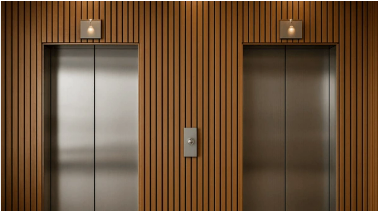

Senaryo: Bir yapı asansöre sahip. Yolcular binadaki farklı katlardan asansör çağırıyor.
Amaç; bekleme süresini azaltmak, enerji tüketimini düşürmek ve verimli yolcu taşımak.

Pekiştirmeli Öğrenme ile Yaklaşım:

ÖNEMLİ BELLMAN KAVRAMLARI

Durum(State): Yönü(yukarı/aşağı) (Katlarda bekleyen yolcuların sayısı, Asansörün mevcut katı, kapasitesi)

Eylem(Action): Bu asansör için hareket kararı(yukarı, aşağı, asansörden inmek, asansöre binmek)

Ödül(Reward): Yolcu indirme +5, yolcuyu zamanında alma +3, boşta gezinme -1

İpucu: Merkezi bir ajan sistemi kontrol edebilir.

**OpenAI Gym Elevator environment**

In [1]:
from contextlib import closing
from io import StringIO
from os import path
from typing import Optional
import numpy as np
import random

from gymnasium import Env, logger, spaces, utils
from gymnasium.envs.toy_text.utils import categorical_sample
from gymnasium.error import DependencyNotInstalled
from gymnasium.envs.registration import register

MAP = [
    "---",
    "| |",
    "| |",
    "| |",
    "---",
]
WINDOW_SIZE = (550, 350)


class ElevatorEnv(Env):

  """

      The Elevator Problem
      from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
      by Tom Dietterich

      ### Description
      The environment represents a 5-story building with a single elevator.
      The elevator moves along its vertical axis, waiting passengers board and
      disembark at a specified target floor. (Initially, code was written that
      kept the target floors for each passenger. However, because I felt this
      approach increased the state space, a common target floor was determined
       for all passengers in the elevator.)

      Map:

            ---
            | |
            | |
            | |
            ---

      ### Actions
      There are 4 discrete deterministic actions:
      - 0: move south
      - 1: move north
      - 2: taking the elevator
      - 3: getting off the elevator

      ### Observations
      There are 2304 discrete states since there are 3 elevator positions, number
      of passengers in the elevator 4 possibilities(including when passengers
      are in the elevator and when they are not), The number of
      passengers waiting on the floor is 4 possibilities(including when passengers
      are in the elevator and when they are not), since the
      building has 3 floors, it is 4^3,  and  3 destination locations.

      Each status field is represented by the following pair: (elevator_row,
      elevator_column, current_passengers, waiting_passenger, destination_floor)

      ### Rewards
      - -1 idle wandering
      - -0.1 reward for reducing energy consumption
      - +3  number of passengers * passenger drop-off
      - +5  number of passengers * pick up the passenger on time
      - -sum(new_waiting) to reduce waiting time
      - The segment ends when all passengers in the elevator are dropped off at the destination floor.

      ### Arguments

      ```
      gym.make('Elevator-v0_by_Zeynep_Erva')
      ```
      ### Version History
        * v0 : The first custom elevator domain created by Zeynep Erva
              Dynamic waiting passengers, capacity restrictions.

  """
  """ Bu çalışmada asansör kapasitesi literatürde yaygın olarak kullanılan
     600–630 kg (yaklaşık 8 kişi) aralığı referans alınarak belirlenmek
     istenmiştir. Ancak modelleme sürecinde durum uzayının (state space)
     boyutu, kullanılan donanımın bellek kapasitesi (RAM) tarafından önemli
     ölçüde etkilenmektedir.

     Geliştirme ortamında bellek sınırlarının aşılmaması ve pekiştirmeli
     öğrenme yöntemlerinin uygulanabilirliğini korumak amacıyla kapasite
     parametresi 225 kg (yaklaşık 3 kişi) olarak yeniden
     tanımlanmıştır. Böylece model hem hesaplama açısından yönetilebilir
     kalmış hem de gerçekçi bir asansör senaryosunu temsil etmeyi
     sürdürmüştür.

     Aynı şekilde, binanın kat sayısı da 6 kat olarak tasarlanmak istenirken
     durum uzayının büyümesini engellemek kat sayısı 3 olarak sınırlandırılmıştır.
     Bu yaklaşım, modelin çalışabilirliğini artırmak için uygulanmıştır.

     Ayrıca, her kattaki bekleyen yolcu sayısı gerçekte yoğunluğa bağlı
     olarak değişkenlik gösterse de, durum uzayının aşırı büyümesini
     engellemek amacıyla maksimum bekleyen yolcu sayısı asansör kapasitesi
     ile sınırlandırılmıştır. Bu yaklaşım, modelin çalışabilirliğini artırmak
     ve öğrenme süresini optimize etmek için uygulanmıştır.
  """
  metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": 4,
    }

  def __init__(self, render_mode: Optional[str] = None, max_capacity=3):
        self.desc = np.asarray(MAP, dtype="c")

        self.max_capacity = max_capacity
        self.num_rows = 3
        self.num_columns = 1
        self.max_row = self.num_rows - 1
        self.max_col = self.num_columns - 1
        self.locs = [(r, c) for r in range(self.num_rows) for c in range(self.num_columns)]
        self.locs_colors = [(128,128,128)] * len(self.locs)
        # Durum uzayı: [elevator_row, elevator_col, current_passengers, *waiting_passengers, dest_idx]
        num_states = (self.num_rows * self.num_columns *
                     (self.max_capacity + 1) *  # asansördeki yolcu sayısı
                     (self.max_capacity + 1) ** self.num_rows *  # her kattaki bekleyen yolcu sayısı
                     len(self.locs))  # hedef kat
        self.initial_state_distrib = np.zeros(num_states)
        self.num_actions = 4

        self.P = {
            state: {action: [] for action in range(self.num_actions)}
            for state in range(num_states)
        }


        for row in range(self.num_rows):
            for col in range(self.num_columns):
                for current_passengers in range(self.max_capacity + 1):
                    for dest_idx in range(len(self.locs)):
                        for waiting_combination in np.ndindex(*[self.max_capacity + 1 for _ in range(self.num_rows)]):
                            state = self.encode(row, col, current_passengers, waiting_combination, dest_idx)

                            if any(waiting_combination) and current_passengers == 0:
                                self.initial_state_distrib[state] += 1

                            for action in range(self.num_actions):
                                new_row, new_col,new_current_passengers = row, col, current_passengers
                                new_waiting = list(waiting_combination)
                                reward = -1
                                terminated = False
                                elevator_loc = (row, col)

                                if action == 0:  # Aşağı
                                    new_row = min(row + 1, self.max_row)
                                    reward -= 0.1 # enerji maliyeti
                                elif action == 1:  # Yukarı
                                    new_row = max(row - 1, 0)
                                    reward -= 0.1
                                elif action == 2: # Asansöre Binme
                                  current_floor_idx = self.locs.index(elevator_loc)
                                  new_current_passengers, new_waiting, binen = self.asansor_islemi( new_waiting, new_current_passengers, current_floor_idx )
                                  reward = +3 * binen

                                elif action == 3:  # Asansörden İnme
                                  if elevator_loc == self.locs[dest_idx] and new_current_passengers > 0:
                                    # Hedef katta asansördeki yolcular iner.
                                    current_floor_idx = self.locs.index(elevator_loc)
                                    inen_yolcu = new_current_passengers
                                    new_current_passengers = 0
                                    terminated = True
                                    reward = +5 * inen_yolcu

                                new_state = self.encode(
                                    new_row, new_col, new_current_passengers, tuple(new_waiting), dest_idx
                                )
                                reward -= sum(new_waiting) # bekleyen yolcular için ceza
                                self.P[state][action].append(
                                    (1.0, new_state, reward, terminated)
                                )

        self.initial_state_distrib /= self.initial_state_distrib.sum()
        self.action_space = spaces.Discrete(self.num_actions)
        self.observation_space = spaces.Discrete(num_states)

        self.render_mode = render_mode


        self.window = None
        self.clock = None
        self.cell_size = (
            WINDOW_SIZE[0] / self.desc.shape[1],
            WINDOW_SIZE[1] / self.desc.shape[0],
        )
        self.elevator_imgs = None
        self.elevator_orientation = 0
        self.passenger_img = None
        self.destination_img = None
        self.median_horiz = None
        self.median_vert = None
        self.background_img = None


  def asansor_islemi(self, waiting_passengers, current_passengers, kat_index):
      """
      Asansör işlemleri: yolcu binme ve kapasite kontrolü
      """
      yeni_bekleyen = waiting_passengers.copy()
      yeni_capacity = current_passengers


      # BİNME İŞLEMİ
      if yeni_bekleyen[kat_index] > 0:
        bos_yer = self.max_capacity - yeni_capacity
        binen_yolcu_sayisi = min(yeni_bekleyen[kat_index], bos_yer)
        yeni_capacity += binen_yolcu_sayisi
        yeni_bekleyen[kat_index] -= binen_yolcu_sayisi
      else:
        binen_yolcu_sayisi = 0
      return yeni_capacity, yeni_bekleyen, binen_yolcu_sayisi


  def encode(self, elevator_row, elevator_col, current_passengers, waiting_passengers, dest_idx):
        """Durumu tek bir tamsayıya dönüştürür (state encoding)"""
        i = elevator_row
        i = i * self.num_columns + elevator_col
        i = i * (self.max_capacity + 1) + current_passengers

        # Bekleyen yolcuları kodla
        for floor in range(self.num_rows):
            i = i * (self.max_capacity + 1) + waiting_passengers[floor]

        i = i * len(self.locs) + dest_idx
        return i

  def decode(self, i):
        """Tamsayıyı duruma geri çevirir (state decoding)"""
        dest_idx = i % len(self.locs)
        i = i // len(self.locs)

        waiting_passengers = []
        for floor in range(self.num_rows-1, -1, -1):
            waiting_passengers.append(i % (self.max_capacity + 1))
            i = i // (self.max_capacity + 1)
        waiting_passengers = tuple(reversed(waiting_passengers))

        current_passengers = i % (self.max_capacity + 1)
        i = i // (self.max_capacity + 1)

        elevator_col = i % self.num_columns
        i = i // self.num_columns
        elevator_row = i

        return elevator_row, elevator_col, current_passengers, waiting_passengers, dest_idx

  def action_mask(self, state: int):
        """Duruma göre aksiyon maskesi oluştur"""
        mask = np.zeros(self.num_actions, dtype=np.int8)
        elevator_row, elevator_col, current_passengers, waiting_passengers, dest_idx = self.decode(state)


        if elevator_row < self.max_row:
            mask[0] = 1


        if elevator_row > 0:
            mask[1] = 1

        # Binme aksiyonu: sadece katta yolcu varsa ve kapasite yeterliyse
        current_floor_idx = self.locs.index((elevator_row, elevator_col))
        if (waiting_passengers[current_floor_idx] > 0 and
            current_passengers < self.max_capacity):
            mask[2] = 1

         # İnme aksiyonu: sadece hedef katta ve yolcu varsa
        if ((elevator_row, elevator_col) == self.locs[dest_idx] and
            current_passengers > 0):
            mask[3] = 1

        return mask

  def get_passenger_info(self, state: int):
      """Asansördeki ve bekleyen yolcu bilgilerini döndürür"""
      elevator_row, elevator_col, current_passengers, waiting_passengers, dest_idx = self.decode(state)
      return {
            'current_passengers': current_passengers,
            'waiting_passengers': waiting_passengers,
            'capacity_remaining': self.max_capacity - current_passengers,
            'destination_floor': self.locs[dest_idx][0],
            'current_floor': elevator_row
      }


  def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        if self.render_mode == "human":
            self.render()
        return (int(s), r, t, False, {"prob": p, "action_mask": self.action_mask(s)})

  def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None
        self.elevator_orientation = 0

        if self.render_mode == "human":
            self.render()

        # Başlangıç durumu bilgilerini yazdır
        passenger_info = self.get_passenger_info(self.s)
        print("AKILLI ASANSÖR KONTROLÜ BAŞLATILDI")
        print(f"Asansör: Kat {passenger_info['current_floor'] + 1}")
        print(f"Asansördeki yolcular: {passenger_info['current_passengers']}/{self.max_capacity}")
        print(f"Hedef kat: {passenger_info['destination_floor'] + 1}")
        print("Bekleyen yolcular:")
        for kat in range(self.num_rows):
            print(f"  Kat {kat + 1}: {passenger_info['waiting_passengers'][kat]} yolcu")
        print("-" * 40)

        return int(self.s), {"prob": 1.0, "action_mask": self.action_mask(self.s)}

  def render(self):
        if self.render_mode is None:
            logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
        if self.render_mode == "ansi":
            return self._render_text()
        else:
            return self._render_gui(self.render_mode)

  def _render_text(self):
        """Metin tabanlı render"""
        desc = self.desc.copy().tolist()
        outfile = StringIO()

        elevator_row, elevator_col, current_passengers, waiting_passengers, dest_idx = self.decode(self.s)

        out = [[c.decode("utf-8") for c in line] for line in desc]

        # Asansör ve yolcu bilgilerini göster
        outfile.write(f"=== AKILLI ASANSÖR SİSTEMİ ===\n")
        outfile.write(f"Asansör: Kat {elevator_row+ 1}\n")
        outfile.write(f"Asansördeki yolcular: {current_passengers}/{self.max_capacity}\n")
        outfile.write(f"Hedef kat: {self.locs[dest_idx][0] + 1}\n")
        outfile.write("Bekleyen yolcular:\n")
        for floor in range(self.num_rows):
            outfile.write(f"  Kat {floor + 1}: {waiting_passengers[floor]} yolcu\n")

        if self.lastaction is not None:
            actions = ["Aşağı", "Yukarı", "Asansöre Binme", "Asansördenİnme"]
            outfile.write(f"Son Aksiyon: {actions[self.lastaction]}\n")

        with closing(outfile):
            return outfile.getvalue()

  def _render_gui(self, mode):
        """Grafik arayüz render"""
        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[toy_text]`"
            )
        self.elevator_img = pygame.image.load("/content/drive/MyDrive/Colab_Notebooks_vize/elevator_3.png")
        if self.window is None:
            pygame.init()
            pygame.display.set_caption("Elevator Simulation")
            if mode == "human":
                self.window = pygame.display.set_mode(WINDOW_SIZE)
            elif mode == "rgb_array":
                self.window = pygame.Surface(WINDOW_SIZE)

        if self.clock is None:
            self.clock = pygame.time.Clock()

        # Fontları yükle
        if not hasattr(self, 'font'):
            self.font = pygame.font.Font(None, 36)
            self.small_font = pygame.font.Font(None, 24)

        # Arka planı temizle
        self.window.fill((255, 255, 255))

        # Asansör bilgilerini al
        elevator_row, elevator_col, current_passengers, waiting_passengers, dest_idx = self.decode(self.s)

        # SOL TARAF: Bilgiler
        info_x = 10
        y_offset = 50

        title = self.font.render("AKILLI ASANSÖR KONTROLÜ", True, (0, 0, 0))
        self.window.blit(title, (info_x, 10))

        elevator_info = self.small_font.render(f"Asansör: Kat {elevator_row + 1}", True, (0, 0, 255))
        self.window.blit(elevator_info, (info_x, y_offset))

        passenger_info = self.small_font.render(f"Yolcular: {current_passengers}/{self.max_capacity}", True, (0, 0, 255))
        self.window.blit(passenger_info, (info_x, y_offset + 30))

        target_info = self.small_font.render(f"Hedef: Kat {self.locs[dest_idx][0] + 1}", True, (255, 0, 0))
        self.window.blit(target_info, (info_x, y_offset + 60))

        if self.lastaction is not None:
            actions = ["Aşağı", "Yukarı", "Asansöre Binme", "Asansörden İnme"]
            action_info = self.small_font.render(f"Son Aksiyon: {actions[self.lastaction]}", True, (0, 100, 0))
            self.window.blit(action_info, (info_x, y_offset + 90))

        # ORTA: Asansör şaftı
        shaft_x = 200
        shaft_width = 100

        # Asansör şaftı çiz
        pygame.draw.rect(self.window, (200, 200, 200),
                        (shaft_x, 50, shaft_width, WINDOW_SIZE[1] - 100))

        # Kat çizgileri ve bilgileri
        for floor in range(self.num_rows):
            floor_y = 50 + (self.num_rows - 1 - floor) * 60

            # Kat çizgisi
            pygame.draw.line(self.window, (0, 0, 0),
                            (shaft_x, floor_y),
                            (shaft_x + shaft_width, floor_y), 2)

            # Kat numarası
            floor_text = self.small_font.render(f"Kat {floor + 1}", True, (0, 0, 0))
            self.window.blit(floor_text, (shaft_x - 50, floor_y - 15))

            # Bekleyen yolcu sayısı
            waiting_text = self.small_font.render(f"Bekleyen: {waiting_passengers[floor]}", True, (255, 0, 0))
            self.window.blit(waiting_text, (shaft_x + shaft_width + 10, floor_y - 15))

            # Asansörü çiz (mevcut katta ise)
            if floor == elevator_row:
                elevator_color = (0, 0, 255)
                self.elevator_img = pygame.transform.scale(self.elevator_img, (shaft_width-10, 50))
                self.window.blit(self.elevator_img, (shaft_x +10, floor_y - 50))

                # Asansördeki yolcu sayısı
                passenger_count = self.small_font.render(str(current_passengers), True, (255, 255, 255))
                self.window.blit(passenger_count,
                               (shaft_x + shaft_width//2 - 5, floor_y - 35))

        if mode == "human":
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        elif mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window)), axes=(1, 0, 2)
            )

  def close(self):
        if self.window is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()

# Ortamı kaydet
register(
    id="Elevator-v0_by_Zeynep_Erva",
    entry_point=__name__ + ":ElevatorEnv",
)

AKILLI ASANSÖR KONTROLÜ BAŞLATILDI
Asansör: Kat 3
Asansördeki yolcular: 0/3
Hedef kat: 1
Bekleyen yolcular:
  Kat 1: 3 yolcu
  Kat 2: 0 yolcu
  Kat 3: 1 yolcu
----------------------------------------


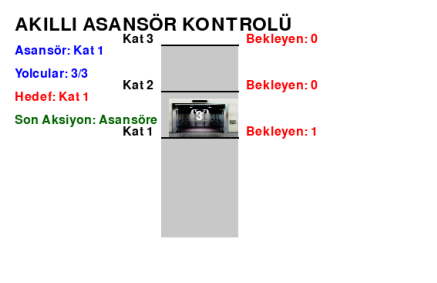

In [2]:
from matplotlib import animation
import matplotlib.pyplot as plt
import gymnasium as gym

"""
Ensure you have imagemagick installed with
sudo apt-get install imagemagick

Open file in CLI with:
xdg-open <filename>
"""

def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        return [patch]

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

env = gym.make("Elevator-v0_by_Zeynep_Erva", render_mode="rgb_array")

obs, info = env.reset()

frames = []
for t in range(1000):

    frame = env.render()
    frames.append(frame)

    action = env.action_space.sample()

    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        break

env.close()

save_frames_as_gif(frames)


In [3]:
"""Install libraries (outcomment commands by removing # and run cell)"""
#!pip install cmake 'gym[atari]' scipy

'Install libraries (outcomment commands by removing # and run cell)'

In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
from matplotlib import animation
import pandas as pd

In [6]:
def run_animation(experience_buffer):
    """Function to run animation"""
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        # Print console output
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")

        # Pauze animation
        sleep(time_lag)

In [7]:
def store_episode_as_gif(experience_buffer, path='./', filename='animation2.gif'):
    """Store episode as gif animation"""
    fps = 5   # Set framew per seconds
    dpi = 30  # Set dots per inch
    interval = 50  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Fix frame size
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Save output as gif
    anim.save(path + filename, writer='imagemagick', fps=fps)

AKILLI ASANSÖR KONTROLÜ BAŞLATILDI
Asansör: Kat 3
Asansördeki yolcular: 0/3
Hedef kat: 3
Bekleyen yolcular:
  Kat 1: 1 yolcu
  Kat 2: 1 yolcu
  Kat 3: 2 yolcu
----------------------------------------
State space: Discrete(2304)
Action space: Discrete(4)
State: 1604
Action: 1
Action mask: [0 1 1 0]
Reward: -5.1


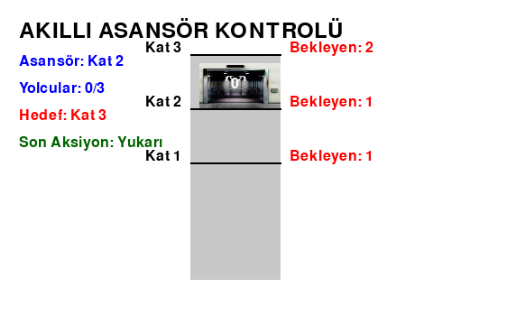

In [8]:

import gymnasium as gym
"""Initialize and validate the environment"""
env = gym.make("Elevator-v0_by_Zeynep_Erva", render_mode="rgb_array").env
state, _ = env.reset()

# Print dimensions of state and action space
print("State space: {}".format(env.observation_space))
print("Action space: {}".format(env.action_space))

action_mask = env.unwrapped.action_mask(state)
valid_actions = np.where(action_mask == 1)[0]

# bunlardan rastgele birini seç
action = np.random.choice(valid_actions)

obs, reward, terminated, truncated, info = env.step(action)

# Print output
print("State: {}".format(state))
print("Action: {}".format(action))
print("Action mask: {}".format(action_mask))
print("Reward: {}".format(reward))

# Render and plot an environment frame
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

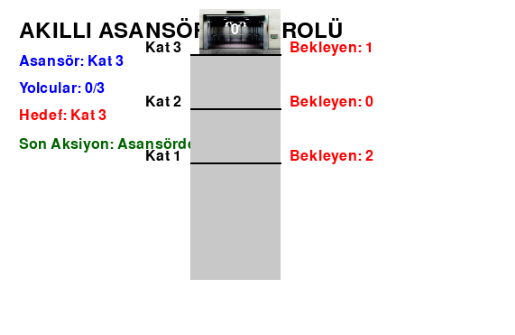

Episode: 10/10
Epoch: 8/8
State: 1637
Action: 3
Reward: -30.6
# epochs: 9
# failed drop-offs: 0


In [9]:
"""Simulation with random agent"""
epoch = 0
num_failed_dropoffs = 0
experience_buffer = []
cum_reward = 0

done = False

state, _ = env.reset()

while not done:
    # Sample random action
    action = env.action_space.sample()
    #action = env.action_space.sample(env.action_mask(state))

    state, reward, done, _, _ = env.step(action)
    cum_reward += reward

    # Store experience in dictionary
    experience_buffer.append({
        "frame": env.render(),
        "episode": 1,
        "epoch": epoch,
        "state": state,
        "action": action,
        "reward": cum_reward,
        }
    )



    epoch += 1

# Run animation and print console output
run_animation(experience_buffer)

print("# epochs: {}".format(epoch))
print("# failed drop-offs: {}".format(num_failed_dropoffs))

Episode #: 10000


===Training completed.===



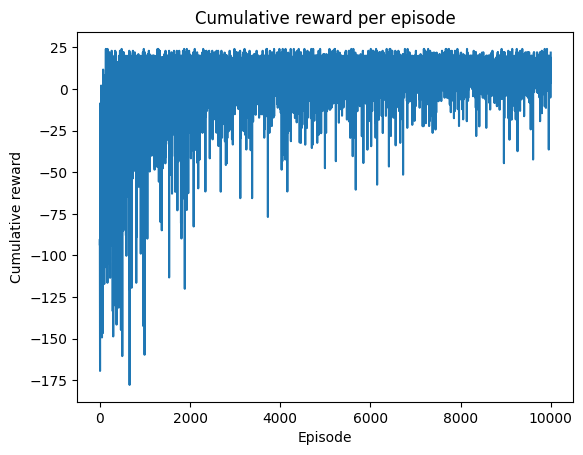

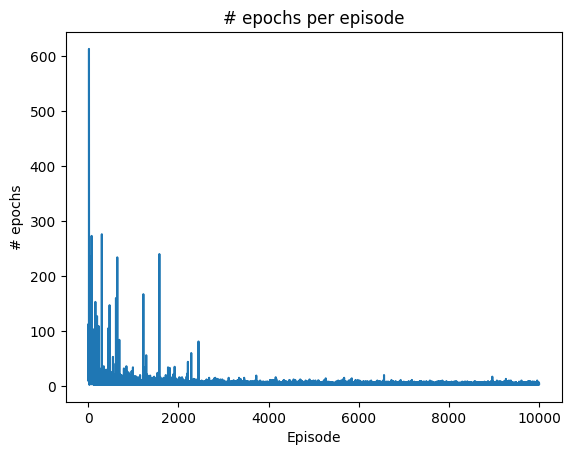


=== Best Model Summary ===
Best cumulative reward: 24
Achieved at episode: 135


KeyboardInterrupt: Interrupted by user

In [17]:
def test_policy_performance():
    """Test policy performance after training"""

    num_epochs = 0
    total_failed_deliveries = 0
    num_episodes = 1
    experience_buffer = []
    store_gif = True

    for episode in range(1, num_episodes+1):
        # Initialize experience buffer

        my_env = env.reset()
        state = my_env[0]
        epoch = 1
        num_failed_deliveries =0
        cum_reward = 0
        done = False

        while not done :
            action = np.argmax(q_table[state])
            state, reward, done, _, _ = env.step(action)
            cum_reward += reward


            # Store rendered frame in animation dictionary
            experience_buffer.append({
                'frame': env.render(),
                'episode': episode,
                'epoch': epoch,
                'state': state,
                'action': action,
                'reward': cum_reward
                }
            )

            epoch += 1

        total_failed_deliveries += num_failed_deliveries
        num_epochs += epoch

        if store_gif:
            store_episode_as_gif(experience_buffer)

    # Run animation and print output
    run_animation(experience_buffer)

    # Print final results
    print("\n")
    print(f"Test results after {num_episodes} episodes:")
    print(f"Mean # epochs per episode: {num_epochs / num_episodes}")
    print(f"Mean # failed drop-offs per episode: {total_failed_deliveries / num_episodes}")

def training():

  import numpy as np

  """Training the agent"""
  global q_table
  q_table = np.zeros([env.observation_space.n, env.action_space.n])

  # Hyperparameters
  alpha = 0.1  # Learning rate
  gamma = 1.0  # Discount rate
  epsilon = 0.1  # Exploration rate
  num_episodes = 10000  # Number of episodes

  # Output for plots
  cum_rewards = np.zeros([num_episodes])
  total_epochs = np.zeros([num_episodes])

  # ⭐ Best Model Tracking
  best_reward = -999999
  best_q_table = None

  for episode in range(1, num_episodes+1):
      # Reset environment
      state, info = env.reset()
      epoch = 0
      num_failed_dropoffs = 0
      done = False
      cum_reward = 0

      while not done :

          if random.uniform(0, 1) < epsilon:
              "Basic exploration [~0.47m]"
              action = env.action_space.sample() # Sample random action (exploration)

              "Exploration with action mask [~1.52m]"
            # action = env.action_space.sample(env.action_mask(state)) "Exploration with action mask"
          else:
              "Exploitation with action mask [~1m52s]"
            # action_mask = np.where(info["action_mask"]==1,0,1) # invert
            # masked_q_values = np.ma.array(q_table[state], mask=action_mask, dtype=np.float32)
            # action = np.ma.argmax(masked_q_values, axis=0)

              "Exploitation with random tie breaker [~1m19s]"
            #  action = np.random.choice(np.flatnonzero(q_table[state] == q_table[state].max()))

              "Basic exploitation [~47s]"
              action = np.argmax(q_table[state]) # Select best known action (exploitation)

          next_state, reward, done, _ , info = env.step(action)

          cum_reward += reward

          old_q_value = q_table[state, action]
          next_max = np.max(q_table[next_state])

          new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)

          q_table[state, action] = new_q_value


          state = next_state
          epoch += 1
          total_epochs[episode-1] = epoch
          cum_rewards[episode-1] = cum_reward



      if episode % 100 == 0:
          clear_output(wait=True)
          print(f"Episode #: {episode}")
      """if episode % 300 == 0:
            test_policy_performance()"""
      # ⭐ Best Model Check
      if cum_reward > best_reward:

            best_reward = cum_reward
            best_episode = episode
            best_q_table = q_table.copy()


  print("\n")
  print("===Training completed.===\n")

  # Plot reward convergence
  plt.title("Cumulative reward per episode")
  plt.xlabel("Episode")
  plt.ylabel("Cumulative reward")
  plt.plot(cum_rewards)
  plt.show()

  # Plot epoch convergence
  plt.title("# epochs per episode")
  plt.xlabel("Episode")
  plt.ylabel("# epochs")
  plt.plot(total_epochs)
  plt.show()

  import pandas as pd
  import numpy as np

  # q_table: önceden oluşturulmuş NumPy array
  # Örnek: q_table.shape = (1080, 6)  # 1080 durum, 6 aksiyon


  df_best = pd.DataFrame(
      best_q_table,
      columns=[f"action_{i}" for i in range(best_q_table.shape[1])]
  )
  df_best.insert(0, "state", range(best_q_table.shape[0]))
  df_best.to_csv("best_model_q_table.csv", index=False)
  # --- NORMAL Q TABLE KAYDETME ---
  df = pd.DataFrame(
      q_table,
      columns=[f"action_{i}" for i in range(q_table.shape[1])]
  )
  df.insert(0, "state", range(q_table.shape[0]))
  df.to_csv("q_table.csv", index=False)
  print("\n=== Best Model Summary ===")
  print(f"Best cumulative reward: {best_reward}")
  print(f"Achieved at episode: {best_episode}")

while True:
  method_argument=input("If you want to train the agent, press t; if you want to test policy performance, press e.")
  if method_argument=="t":
    training()
  elif method_argument=="e":
    test_policy_performance()
  else:
    break

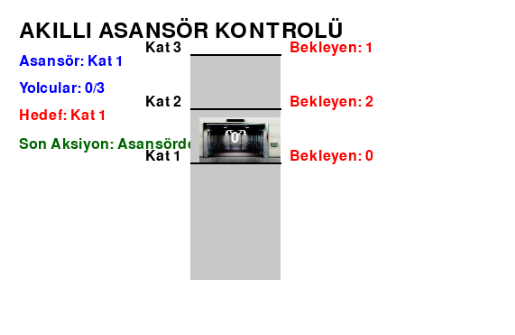

Episode: 1/1
Epoch: 2/2
State: 27
Action: 3
Reward: 10


Test results after 1 episodes:
Mean # epochs per episode: 3.0
Mean # failed drop-offs per episode: 0.0
If you want to train the agent, press t; if you want to test policy performance, press e.q


In [ ]:
def test_policy_performance():
    """Test policy performance after training"""

    num_epochs = 0
    total_failed_deliveries = 0
    num_episodes = 1
    experience_buffer = []
    store_gif = True

    for episode in range(1, num_episodes+1):
        # Initialize experience buffer

        my_env = env.reset()
        state = my_env[0]
        epoch = 1
        num_failed_deliveries =0
        cum_reward = 0
        done = False

        while not done :
            action = np.argmax(q_table[state])
            state, reward, done, _, _ = env.step(action)
            cum_reward += reward


            # Store rendered frame in animation dictionary
            experience_buffer.append({
                'frame': env.render(),
                'episode': episode,
                'epoch': epoch,
                'state': state,
                'action': action,
                'reward': cum_reward
                }
            )

            epoch += 1

        total_failed_deliveries += num_failed_deliveries
        num_epochs += epoch

        if store_gif:
            store_episode_as_gif(experience_buffer)

    # Run animation and print output
    run_animation(experience_buffer)

    # Print final results
    print("\n")
    print(f"Test results after {num_episodes} episodes:")
    print(f"Mean # epochs per episode: {num_epochs / num_episodes}")
    print(f"Mean # failed drop-offs per episode: {total_failed_deliveries / num_episodes}")

def training():

  import numpy as np

  """Training the agent"""
  global q_table
  q_table = np.zeros([env.observation_space.n, env.action_space.n])

  # Hyperparameters
  alpha = 0.1  # Learning rate
  gamma = 1.0  # Discount rate
  epsilon = 0.1  # Exploration rate
  num_episodes = 10000  # Number of episodes

  # Output for plots
  cum_rewards = np.zeros([num_episodes])
  total_epochs = np.zeros([num_episodes])

  # ⭐ Best Model Tracking
  best_reward = -999999
  best_q_table = None

  for episode in range(1, num_episodes+1):
      # Reset environment
      state, info = env.reset()
      epoch = 0
      num_failed_dropoffs = 0
      done = False
      cum_reward = 0

      while not done :

          if random.uniform(0, 1) < epsilon:
              "Basic exploration [~0.47m]"
              action = env.action_space.sample() # Sample random action (exploration)

              "Exploration with action mask [~1.52m]"
            # action = env.action_space.sample(env.action_mask(state)) "Exploration with action mask"
          else:
              "Exploitation with action mask [~1m52s]"
            # action_mask = np.where(info["action_mask"]==1,0,1) # invert
            # masked_q_values = np.ma.array(q_table[state], mask=action_mask, dtype=np.float32)
            # action = np.ma.argmax(masked_q_values, axis=0)

              "Exploitation with random tie breaker [~1m19s]"
            #  action = np.random.choice(np.flatnonzero(q_table[state] == q_table[state].max()))

              "Basic exploitation [~47s]"
              action = np.argmax(q_table[state]) # Select best known action (exploitation)

          next_state, reward, done, _ , info = env.step(action)

          cum_reward += reward

          old_q_value = q_table[state, action]
          next_max = np.max(q_table[next_state])

          new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)

          q_table[state, action] = new_q_value



          state = next_state
          epoch += 1
          total_epochs[episode-1] = epoch
          cum_rewards[episode-1] = cum_reward

          # ⭐ Best Model Check
          if cum_reward > best_reward:
            best_reward = cum_reward
            best_q_table = q_table.copy()

      if episode % 100 == 0:
          clear_output(wait=True)
          print(f"Episode #: {episode}")
      """if episode % 300 == 0:
            test_policy_performance()"""




  print("\n")
  print("===Training completed.===\n")

  # Plot reward convergence
  plt.title("Cumulative reward per episode")
  plt.xlabel("Episode")
  plt.ylabel("Cumulative reward")
  plt.plot(cum_rewards)
  plt.show()

  # Plot epoch convergence
  plt.title("# epochs per episode")
  plt.xlabel("Episode")
  plt.ylabel("# epochs")
  plt.plot(total_epochs)
  plt.show()

  import pandas as pd
  import numpy as np

  # q_table: önceden oluşturulmuş NumPy array
  # Örnek: q_table.shape = (1080, 6)  # 1080 durum, 6 aksiyon


  df_best = pd.DataFrame(
      best_q_table,
      columns=[f"action_{i}" for i in range(best_q_table.shape[1])]
  )
  df_best.insert(0, "state", range(best_q_table.shape[0]))
  df_best.to_csv("best_model_q_table.csv", index=False)
  # --- NORMAL Q TABLE KAYDETME ---
  df = pd.DataFrame(
      q_table,
      columns=[f"action_{i}" for i in range(q_table.shape[1])]
  )
  df.insert(0, "state", range(q_table.shape[0]))
  df.to_csv("q_table.csv", index=False)



while True:
  method_argument=input("If you want to train the agent, press t; if you want to test policy performance, press e.")
  if method_argument=="t":
    training()
  elif method_argument=="e":
    test_policy_performance()
  else:
    break